In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Paths
BASE_DIR = Path(r'c:\Users\Acer\Desktop\Forex-Signal-App')
DATA_DIR = BASE_DIR / 'data'
MODEL_DIR = BASE_DIR / 'models' / 'signal_generator_v19'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Constants
# Excluding 1min and 5min as they are too noisy
TIMEFRAMES = ['15min', '30min', '1h', '4h'] 
FORWARD_BARS = 24          
ATR_PERIOD = 14
TP_ATR_MULT = 1.5          
SL_ATR_MULT = 1.0          

print(f"🚀 FOREX SIGNAL V19: Advanced Features + Trend Filtering")
print(f"✓ Model Directory: {MODEL_DIR}")
print(f"✓ Timeframes: {TIMEFRAMES}")

🚀 FOREX SIGNAL V19: Advanced Features + Trend Filtering
✓ Model Directory: c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v19
✓ Timeframes: ['15min', '30min', '1h', '4h']


In [9]:
# 1. Load Data
def load_tf_data(timeframe, dataset_type='train'):
    filename = f'EURUSD_{timeframe}.csv'
    file_path = DATA_DIR / dataset_type / filename
        
    if not file_path.exists():
        print(f"⚠️ Warning: {file_path} not found.")
        return None
        
    df = pd.read_csv(file_path)
    df.columns = [c.lower() for c in df.columns]
    
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
    
    return df

timeframes_map = {
    '1min': 'm1',
    '5min': 'm5',
    '15min': 'm15',
    '30min': 'm30',
    '1h': 'h1',
    '4h': 'h4'
}

dfs_train = {}
dfs_test = {}

print("Loading TRAIN data...")
for tf_name, tf_code in timeframes_map.items():
    df = load_tf_data(tf_code, 'train')
    if df is not None:
        dfs_train[tf_name] = df
        print(f"  Loaded {tf_name}: {len(df)} rows")

print("\nLoading TEST data...")
for tf_name, tf_code in timeframes_map.items():
    df = load_tf_data(tf_code, 'test')
    if df is not None:
        dfs_test[tf_name] = df
        print(f"  Loaded {tf_name}: {len(df)} rows")

Loading TRAIN data...
  Loaded 1min: 3354904 rows
  Loaded 5min: 671581 rows
  Loaded 15min: 224382 rows
  Loaded 30min: 112194 rows
  Loaded 1h: 56098 rows
  Loaded 4h: 14498 rows

Loading TEST data...
  Loaded 1min: 743476 rows
  Loaded 5min: 148502 rows
  Loaded 15min: 49807 rows
  Loaded 30min: 24907 rows
  Loaded 1h: 12454 rows
  Loaded 4h: 3220 rows


In [10]:
# 2. Advanced Feature Engineering (ADX, Lags, Volatility)

def calculate_adx(df, period=14):
    """Calculate ADX manually to avoid dependency issues"""
    df = df.copy()
    
    # True Range
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = (df['high'] - df['close'].shift(1)).abs()
    df['l-pc'] = (df['low'] - df['close'].shift(1)).abs()
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    
    # Directional Movement
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    
    # Smoothed
    df['tr_smooth'] = df['tr'].rolling(window=period).mean() # Simple moving average for simplicity in this version
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    
    df['dx'] = (abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di']) * 100)
    df['adx'] = df['dx'].rolling(window=period).mean()
    
    return df['adx'], df['plus_di'], df['minus_di']

def add_features_v19(df):
    if df is None or len(df) == 0:
        return None
    df = df.copy()
    
    # --- 1. Volatility & Trend (ATR & ADX) ---
    # ATR
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['atr'] = true_range.rolling(ATR_PERIOD).mean()
    
    # ADX (Trend Strength)
    df['adx'], df['plus_di'], df['minus_di'] = calculate_adx(df, 14)
    
    # --- 2. Lagged Returns (Momentum) ---
    # Capture price changes over different horizons
    for lag in [1, 3, 5, 8, 13]:
        df[f'return_lag_{lag}'] = df['close'].pct_change(lag)
        
    # --- 3. Rolling Statistics ---
    # Volatility (Standard Deviation of returns)
    df['volatility_20'] = df['close'].pct_change().rolling(window=20).std()
    
    # Distance from Moving Averages
    for p in [20, 50, 200]:
        df[f'ema_{p}'] = df['close'].ewm(span=p, adjust=False).mean()
        df[f'dist_ema_{p}'] = (df['close'] - df[f'ema_{p}']) / df[f'ema_{p}']
        
    # --- 4. Oscillators ---
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    
    # --- 5. Time Features ---
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    # Drop NaNs created by lags and rolling windows
    return df.dropna()

print("Processing V19 features (ADX, Lags, Volatility)...")
processed_train = {k: add_features_v19(v) for k, v in dfs_train.items()}
processed_test = {k: add_features_v19(v) for k, v in dfs_test.items()}
print("Done.")

Processing V19 features (ADX, Lags, Volatility)...
Done.


In [11]:
# 3. Target Creation (Buy Only with Dynamic ATR)
def create_buy_target(df, tp_mult, sl_mult, forward_bars):
    targets = []
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry = closes[i]
        atr = atrs[i]
        
        if np.isnan(atr) or atr == 0:
            targets.append(0)
            continue
            
        tp = entry + (atr * tp_mult)
        sl = entry - (atr * sl_mult)
        
        outcome = 0 # 0 = WAIT/LOSS
        
        for j in range(1, forward_bars + 1):
            future_high = highs[i+j]
            future_low = lows[i+j]
            
            # Check SL first (conservative)
            if future_low <= sl:
                outcome = 0
                break
            
            # Check TP
            if future_high >= tp:
                outcome = 1 # BUY WIN
                break
                
        targets.append(outcome)
        
    targets.extend([0] * forward_bars)
    return np.array(targets)

print("Creating Targets...")
train_datasets = {}
test_datasets = {}

for tf, df in processed_train.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        train_datasets[tf] = df.iloc[:-FORWARD_BARS]
        print(f"  {tf}: Buy Signals = {df['target'].sum()} ({df['target'].mean()*100:.2f}%)")

for tf, df in processed_test.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        test_datasets[tf] = df.iloc[:-FORWARD_BARS]

Creating Targets...
  1min: Buy Signals = 1372438 (40.93%)
  5min: Buy Signals = 263050 (39.17%)
  15min: Buy Signals = 83717 (37.31%)
  30min: Buy Signals = 41791 (37.26%)
  1h: Buy Signals = 21953 (39.15%)
  4h: Buy Signals = 5649 (39.03%)


In [12]:
# 4. Train XGBoost with Advanced Features
models = {}
scalers = {}
feature_cols_dict = {}

for tf, df_train in train_datasets.items():
    print(f"\nTraining {tf}...")
    
    # Exclude non-feature columns
    exclude_cols = ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume', 'atr', 
                    'h-l', 'h-pc', 'l-pc', 'tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm', 'tr_smooth', 'dx'] # Intermediate ADX cols
    
    cols = [c for c in df_train.columns if c not in exclude_cols]
    
    X_train = df_train[cols]
    y_train = df_train['target']
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Calculate scale_pos_weight
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    print(f"  Features: {len(cols)}")
    print(f"  Positives: {n_pos}, Negatives: {n_neg}, Weight: {scale_weight:.2f}")
    
    model = xgb.XGBClassifier(
        n_estimators=800,          # Increased estimators
        learning_rate=0.03,        # Slower learning
        max_depth=7,               # Slightly deeper for complex interactions
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    models[tf] = model
    scalers[tf] = scaler
    feature_cols_dict[tf] = cols
    
    # Feature Importance
    importances = pd.DataFrame({
        'feature': cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"  Top 5 Features: {importances['feature'].head(5).tolist()}")

print("\nTraining Complete.")


Training 1min...
  Features: 20
  Positives: 1372438, Negatives: 1981066, Weight: 1.44
  Top 5 Features: ['dist_ema_20', 'hour', 'dist_ema_200', 'ema_200', 'ema_50']

Training 5min...
  Features: 20
  Positives: 263050, Negatives: 408481, Weight: 1.55
  Top 5 Features: ['hour', 'dist_ema_20', 'ema_200', 'ema_50', 'day_of_week']

Training 15min...
  Features: 20
  Positives: 83717, Negatives: 140615, Weight: 1.68
  Top 5 Features: ['hour', 'ema_200', 'ema_50', 'day_of_week', 'dist_ema_200']

Training 30min...
  Features: 20
  Positives: 41791, Negatives: 70353, Weight: 1.68
  Top 5 Features: ['ema_200', 'hour', 'ema_50', 'day_of_week', 'dist_ema_200']

Training 1h...
  Features: 20
  Positives: 21953, Negatives: 34095, Weight: 1.55
  Top 5 Features: ['ema_50', 'ema_200', 'dist_ema_200', 'ema_20', 'volatility_20']

Training 4h...
  Features: 20
  Positives: 5649, Negatives: 8799, Weight: 1.56
  Top 5 Features: ['ema_200', 'ema_50', 'ema_20', 'dist_ema_200', 'dist_ema_20']

Training Comp


==================== 1min EVALUATION ====================
Accuracy: 0.5117
              precision    recall  f1-score   support

           0       0.60      0.51      0.55    438574
           1       0.42      0.51      0.46    304782

    accuracy                           0.51    743356
   macro avg       0.51      0.51      0.51    743356
weighted avg       0.53      0.51      0.52    743356



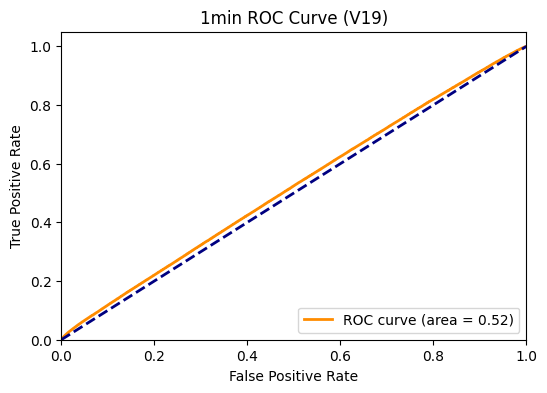


==================== 5min EVALUATION ====================
Accuracy: 0.5222
              precision    recall  f1-score   support

           0       0.62      0.55      0.58     89625
           1       0.41      0.48      0.44     58827

    accuracy                           0.52    148452
   macro avg       0.51      0.51      0.51    148452
weighted avg       0.54      0.52      0.53    148452



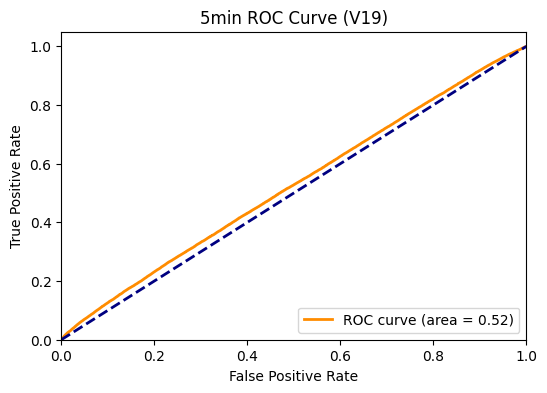


==================== 15min EVALUATION ====================
Accuracy: 0.5254
              precision    recall  f1-score   support

           0       0.64      0.54      0.59     30926
           1       0.40      0.50      0.44     18831

    accuracy                           0.53     49757
   macro avg       0.52      0.52      0.51     49757
weighted avg       0.55      0.53      0.53     49757



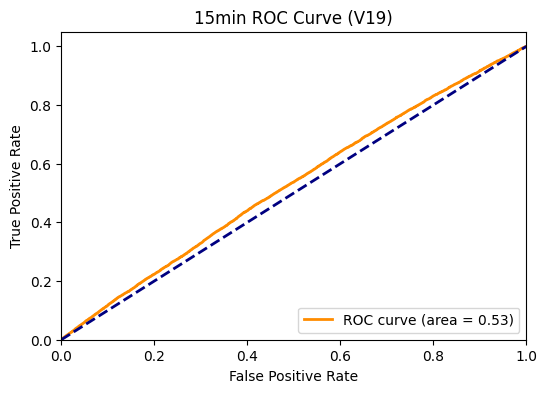


==================== 30min EVALUATION ====================
Accuracy: 0.5223
              precision    recall  f1-score   support

           0       0.63      0.55      0.59     15416
           1       0.39      0.47      0.43      9441

    accuracy                           0.52     24857
   macro avg       0.51      0.51      0.51     24857
weighted avg       0.54      0.52      0.53     24857



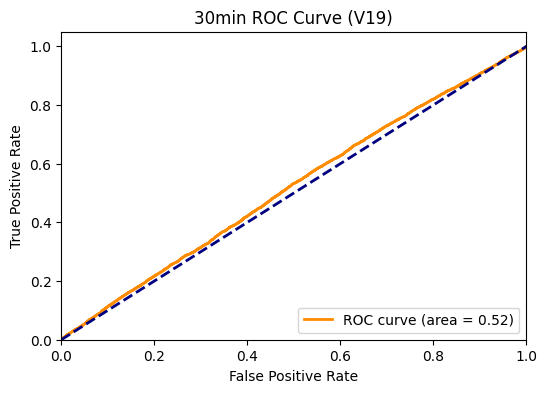


==================== 1h EVALUATION ====================
Accuracy: 0.5064
              precision    recall  f1-score   support

           0       0.61      0.53      0.57      7533
           1       0.39      0.47      0.43      4871

    accuracy                           0.51     12404
   macro avg       0.50      0.50      0.50     12404
weighted avg       0.52      0.51      0.51     12404



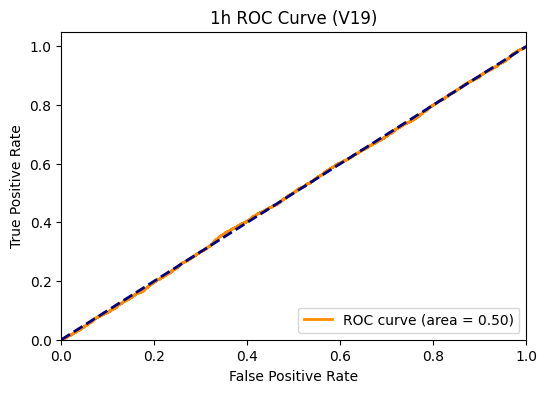


==================== 4h EVALUATION ====================
Accuracy: 0.5268
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1882
           1       0.42      0.43      0.43      1288

    accuracy                           0.53      3170
   macro avg       0.51      0.51      0.51      3170
weighted avg       0.53      0.53      0.53      3170



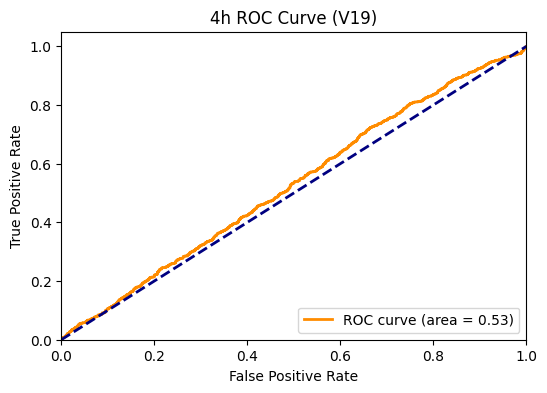

In [13]:
# 5. Evaluation
def evaluate_model_v19(model, scaler, df, cols, tf_name):
    X = df[cols]
    y_true = df['target']
    X_scaled = scaler.transform(X)
    
    # Predict Probabilities
    y_probs = model.predict_proba(X_scaled)[:, 1]
    
    # Thresholding
    threshold = 0.5
    y_pred = (y_probs > threshold).astype(int)
    
    print(f"\n{'='*20} {tf_name} EVALUATION {'='*20}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{tf_name} ROC Curve (V19)')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_probs

# Evaluate on Test Data
for tf, df_test in test_datasets.items():
    if tf in models:
        evaluate_model_v19(models[tf], scalers[tf], df_test, feature_cols_dict[tf], tf)

In [14]:
# 6. Save Models
joblib.dump(models, MODEL_DIR / 'models_dict_v19.joblib')
joblib.dump(scalers, MODEL_DIR / 'scalers_dict_v19.joblib')
joblib.dump(feature_cols_dict, MODEL_DIR / 'feature_cols_dict_v19.joblib')

config = {
    'timeframes': TIMEFRAMES,
    'tp_atr_mult': TP_ATR_MULT,
    'sl_atr_mult': SL_ATR_MULT,
    'forward_bars': FORWARD_BARS,
    'strategy': 'v19_advanced_features'
}
joblib.dump(config, MODEL_DIR / 'config_v19.joblib')
print("Models saved.")

Models saved.
